# ElementOutput

This class is used to handle the element output of AxiSEM3D. Using the element output we can have access to the full wavefiled over some preselected regions of the computation domain, rather than time series at a number of prespecified stations. The downside of this output is that it requires large amounts of disk space, it slows down the simulation (because of the write operations) and the output is given as Lagrange-Gauss coefficients which must be interpolated. Nonetheless, this output type is needed for computing sensitivity kernels and can offer great versatility for visualizing the data. 

In [1]:
from axikernels.core.handlers import element_output
import matplotlib.pyplot as plt
import numpy as np

QStandardPaths: wrong permissions on runtime directory /mnt/wslg/runtime-dir, 0777 instead of 0700


Similar to the *StationOutput* class, we must pass the path to the element output of our simulation:

In [2]:
data = element_output.ElementOutput(path_to_element_output='data/HANDLERS_EXAMPLE/output/elements')

Since the *ElementOutput* class is a child of the *AxiSEM3DOutput* class, we will have at our disposal all its methods and attribute, including the *catalogue* property:

In [3]:
data.catalogue

Event:	1970-01-01T00:00:00.000000Z |  +0.000,   +0.000 | manual

	      resource_id: ResourceIdentifier(id="smi:local/85fc2781-677c-487b-b608-e8c3935d616f")
	             ---------
	 focal_mechanisms: 1 Elements
	          origins: 1 Elements

The *StationOutput* class uses the station file from the simulation input directory to create an Obspy inventory. However, the elements output does not require any prespecified stations, and therefore the class *ElementOutput* does not produce any inventory. We can, however, pick a station file and pass it to the *.create_inventory()* method, which will produce an inventory based on that station file. 

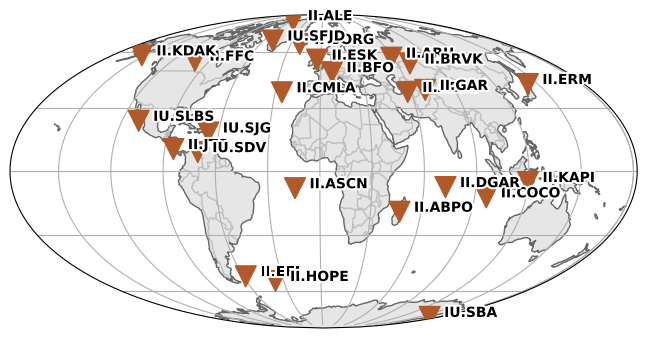

In [4]:
%matplotlib inline
inv = data.create_inventory(path_to_station_file='data/HANDLERS_EXAMPLE/input/GSN_small.txt')
inv.plot()
plt.show()

The most important method of the *ElementOutput* class is *.load_data()*, which can take an array of points ([rad, lat lon] format) and specified channels, and output the interpolated wavefield.  

Loading and interpolating: 100%|██████████| 1/1 [00:00<00:00, 110.08point/s]


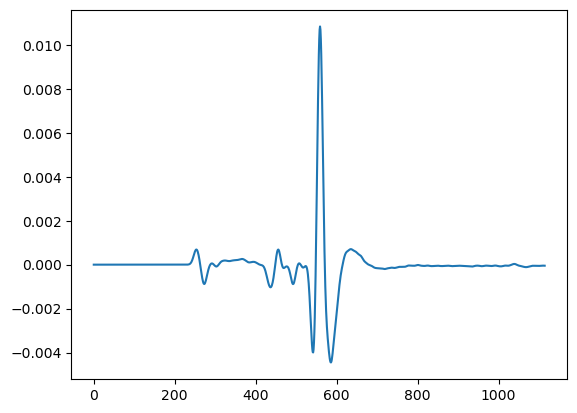

In [5]:
points = np.array([6371000, 30, 0])
wavedata = data.load_data(points, channels=['UZ'])
plt.plot(wavedata[0][0])
plt.show()

ALternatively, we can use the *.stream()* function to  load the data as an obspy stream:

Loading and interpolating: 100%|██████████| 1/1 [00:00<00:00, 378.27point/s]


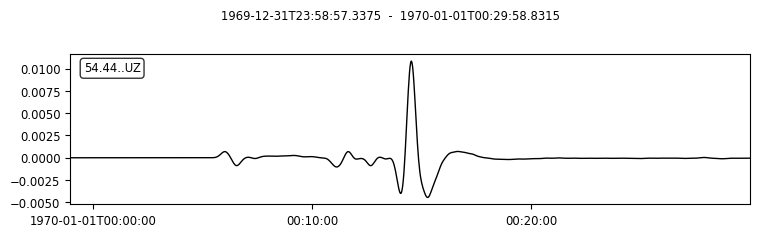

In [6]:
data_stream = data.stream(points=points, channels=['UZ'])
data_stream.plot()
plt.show()

Because we have the entire wavefield at our disposal, we can also produce animations of it. The *.animation()* method takes in the following arguments:
- source_location, station_location: These two points, together with Earth's center, determine a unique great circle slice through the Earth.
- domains: By default the animation will be done on all the element groups specified in the inparam.output.yaml file under the elements section. However, we can further restrict the animation domain by passing an additiona list of domains in the form [[rad_min, rad_max, theta_min, theta_max],[rad_min, rad_max, theta_min, theta_max],...] where rad_min and rad_max are the radius bounds and theta_min theta_max are the azimuthat bounds where theta is measured in radians from the source location to the station location.
- channels: The channels to plot (for ex. ['GZZ', 'GRR', 'GTT'])
- reslution: The animation mesh will have resolution X resolution points on it
- video_duration: Duration in seconds (has nothing to do with the time of the simulation - the entire simulation times will be displayed)
- frame_rate: frame rate in frames per second
- name: the name of the mp4 file that will be saved inside the output/elements directory



Loading and interpolating: 100%|██████████| 7668/7668 [00:41<00:00, 182.83point/s]
/home/adrian/PhD/AxiSEM3D/AxiSEM3D_Kernels/axikernels/core/handlers/element_output.py:1016: RuntimeWarning: divide by zero encountered in log10
  processed_values = np.log10(np.abs(inplane_field))


0.0 %
0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %


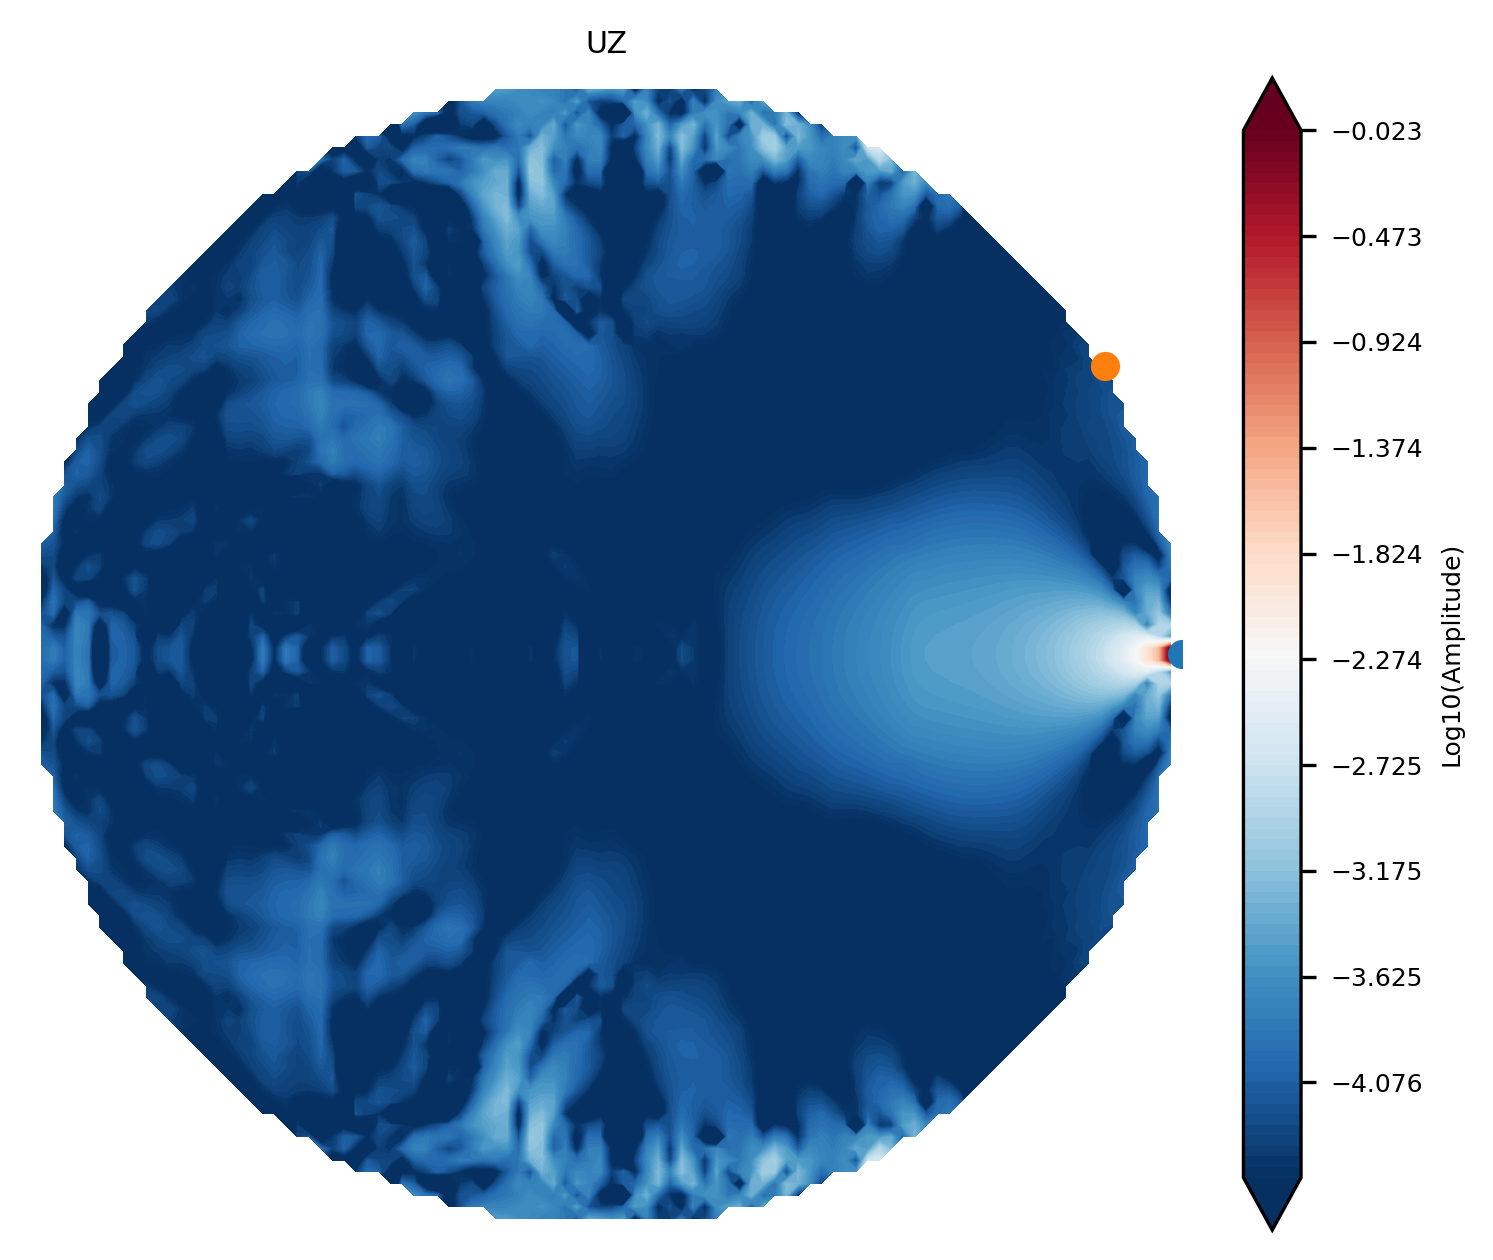

In [7]:
data.animation([6371000, 0, 0], [6371000, 0, 30], channels=['UZ'], resolution=100)